<a href="https://colab.research.google.com/github/SKam23/10315-Final-Project/blob/main/10315_Final_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 10-315 ML Final Project - Smile Detector
_**Authors:** by Shaheer Aslam, Steven Kam, and Sajan Shah_

## Introduction

In [175]:
train_flag = True

## Library Imports

In [176]:
import importlib
import torch 
import torchvision
import torchvision.transforms as transforms
import pandas as pd
import matplotlib.pyplot as plt
import os
import numpy as np
import torchvision.transforms.functional as TF
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import ToTensor
from PIL import Image
from torchvision.utils import make_grid
from IPython.display import display
import csv
# import dependencies
from google.colab.output import eval_js
from base64 import b64decode, b64encode
import cv2
import numpy as np
import PIL
import io
import html
import time
from tensorflow.keras.utils import img_to_array

# CelebA Dataset Processing

In [177]:
!git clone https://github.com/SKam23/SmileData.git

fatal: destination path 'SmileData' already exists and is not an empty directory.


In [178]:
# load images into a dictionary for easier access
images = {}
for filename in os.listdir('./SmileData/selected_images10k/'):
    if filename.endswith('.jpg'):
        image = Image.open(os.path.join('./SmileData/selected_images10k/', filename))
        images[filename] = image


In [179]:
# list_eval_partition.csv: Recommended partitioning of images into training, validation, testing sets. Images 1-162770 are training, 162771-182637 are validation, 182638-202599 are testing
# list_bbox_celeba.csv: Bounding box information for each image. "x_1" and "y_1" represent the upper left point coordinate of bounding box. "width" and "height" represent the width and height of bounding box
# list_landmarks_align_celeba.csv: Image landmarks and their respective coordinates. There are 5 landmarks: left eye, right eye, nose, left mouth, right mouth
# list_attr_celeba.csv: Attribute labels for each image. There are 40 attributes. "1" represents positive while "-1" represents negative
partition_df = pd.read_csv('./SmileData/list_eval_partition10000Smile.csv')
bbox_df = pd.read_csv('./SmileData/list_bbox_celeba10000Smile.csv')
landmarks_df = pd.read_csv('./SmileData/list_landmarks_align_celeba10000Smile.csv')
attr_df = pd.read_csv('./SmileData/list_attr_celeba10000Smile.csv')

In [180]:
merged_df = partition_df.merge(bbox_df, on='image_id').merge(landmarks_df, on='image_id').merge(attr_df, on='image_id')
train_df = merged_df[merged_df['partition'] == 0]
val_df = merged_df[merged_df['partition'] == 1]
test_df = merged_df[merged_df['partition'] == 2]

In [181]:
class CelebADataset(Dataset):
    def __init__(self, df, images):
        self.df = df
        self.images = images
        self.transform = transforms.Compose([transforms.Resize((178, 178)),transforms.ToTensor(),])
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx, random = False):
        row = self.df.iloc[idx]
        image_id = row['image_id']
        image = self.images[image_id]
        image = self.transform(image)
        is_smiling = row["Smiling"] == 1
        label = 1 if is_smiling else 0
        if random:
          return image, (label, image_id)
        else:
          return image,label

In [182]:
train_dataset = CelebADataset(train_df, images)
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)

val_dataset = CelebADataset(val_df, images)
val_dataloader = DataLoader(val_dataset, batch_size=64, shuffle=True)

test_dataset = CelebADataset(test_df, images)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=True)

In [183]:
import random

def get_random_images(dataset):
    smile_images = []
    not_smile_images = []
    
    for i in range(1000):
        image, label = train_dataset.__getitem__(i, True)
        if label[0] == 1:
            smile_images.append(dataset.images[label[1]])
        else:
            not_smile_images.append(dataset.images[label[1]])
    smile_image = random.choice(smile_images)
    not_smile_image = random.choice(not_smile_images)

    
    return smile_image, not_smile_image


## Example of Smiling / Not Smiling

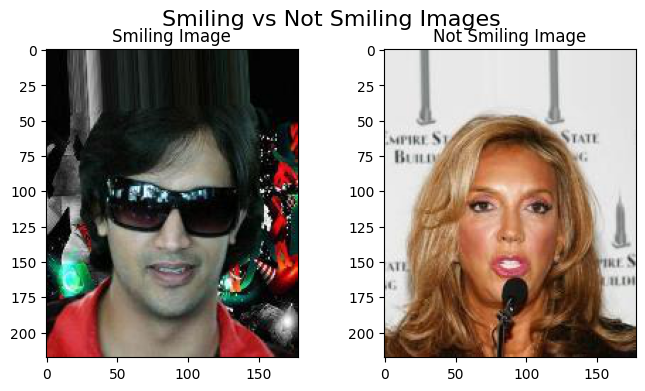

In [184]:
young_image, not_young_image = get_random_images(train_dataset)

# Create a figure and set title
fig = plt.figure(figsize=(8, 4))
fig.suptitle('Smiling vs Not Smiling Images', fontsize=16)

# Add young image to subplot 1
ax1 = fig.add_subplot(1, 2, 1)
ax1.imshow(young_image)
ax1.set_title('Smiling Image')

# Add not young image to subplot 2
ax2 = fig.add_subplot(1, 2, 2)
ax2.imshow(not_young_image)
ax2.set_title('Not Smiling Image')

plt.show()

# Convolutional Neural Network
< explanation >

In [185]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(64 * 44 * 44, 128)
        self.fc2 = nn.Linear(128, 2)
        self.dropout = nn.Dropout(p=0.5)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [186]:
class FCN(nn.Module):
    def __init__(self):
        super(FCN, self).__init__()
        self.fc1 = nn.Linear(3 * 178 * 178, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 2)
        self.dropout = nn.Dropout(p=0.5)

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = F.relu(self.fc3(x))
        return x


In [187]:
import torch.nn.functional as F
from torchvision import models
class MobileNet(nn.Module):
    def __init__(self, pretrained=True):
        super(MobileNet, self).__init__()
        self.model = models.mobilenet_v2(pretrained=pretrained)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        
    def forward(self, x):
        x = self.model.features(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.model.classifier(x)
        return x


In [188]:
import torch.nn.functional as F

def train(model, train_dataloader, val_dataloader, num_epochs, FCN=False):
    # define loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    train_losses, val_losses = [], []
    train_accs, val_accs = [], []

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)

    for epoch in range(num_epochs):
        # training loop
        model.train()
        train_loss = 0.0
        train_correct = 0
        train_total = 0
        for inputs, targets in train_dataloader:
          optimizer.zero_grad()
          if FCN:
            inputs = inputs.view(inputs.size(0), -1)  # flatten input
          inputs = inputs.to(device)
          targets = targets.to(device)
          outputs = model(inputs)
          _, predicted = torch.max(outputs.data, 1)
          targets_onehot = F.one_hot(targets, num_classes=2).float().to(device)  # convert targets to one-hot format
          loss = criterion(outputs, targets)
          loss.backward()
          optimizer.step()
          train_loss += loss.item() * inputs.size(0)
          train_total += targets.size(0)
          train_correct += (predicted == targets).sum().item()
        train_loss /= len(train_dataloader.dataset)
        train_losses.append(train_loss)
        train_acc = train_correct / train_total
        train_accs.append(train_acc)

        # validation loop
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0
        with torch.no_grad():
            for inputs, targets in val_dataloader:
                if FCN:
                  inputs = inputs.view(inputs.size(0), -1)  # flatten input
                inputs = inputs.to(device)
                targets = targets.to(device)
                outputs = model(inputs)
                _, predicted = torch.max(outputs.data, 1)
                loss = criterion(outputs, targets)
                val_loss += loss.item() * inputs.size(0)
                val_total += targets.size(0)
                val_correct += (predicted == targets).sum().item()
            val_loss /= len(val_dataloader.dataset)
            val_losses.append(val_loss)
            val_acc = val_correct / val_total
            val_accs.append(val_acc)

        # print progress
        print(f'Epoch [{epoch + 1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')

    return model, train_losses, val_losses, train_accs, val_accs


In [189]:
def getLossesAccs(filename):
  # open the file in read mode
  with open(filename, mode='r') as file:
    # create a csv reader object
    reader = csv.reader(file)
    # read the header row and discard it
    header = next(reader)
    # initialize empty lists to store the data
    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []
    # read the data rows and append the values to the corresponding lists
    for row in reader:
        train_losses.append(float(row[0]))
        val_losses.append(float(row[1]))
        train_accs.append(float(row[2]))
        val_accs.append(float(row[3]))
    return train_losses, val_losses, train_accs, val_accs

## Training

In [190]:
# if train flag is true, we train the models and get losses, accs
if train_flag:
  mobilenet = torchvision.models.mobilenet_v2()
  model, train_losses, val_losses, train_accs, val_accs = train(CNN(), train_dataloader,val_dataloader,10)
  print("CNN Model done training!")
  FCNmodel, FCNtrain_losses, FCNval_losses, FCNtrain_accs, FCNval_accs =   train(FCN(), train_dataloader,val_dataloader,10, True)
  print("FCN Model done training!")
  pFCNmodel, pFCNtrain_losses, pFCNval_losses, pFCNtrain_accs, pFCNval_accs = train(MobileNet(True), train_dataloader,val_dataloader,10, False)
  print("Pretrained MobileNet Model done training!")
# otherwise, load them in
else:
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  modelDict, FCNmodelDict, pFCNmodelDict = torch.load('./SmileData/models/CNN-Model.pt'), torch.load('./SmileData/models/FCN-Model.pt'), torch.load('./SmileData/models/pFCN-Model.pt')
  model, FCNmodel, pFCNmodel = CNN(), FCN(), MobileNet(True)
  model.load_state_dict(modelDict)
  FCNmodel.load_state_dict(FCNmodelDict)
  pFCNmodel.load_state_dict(pFCNmodelDict)
  model = model.to(device)
  FCNmodel = FCNmodel.to(device)
  pFCNmodel = pFCNmodel.to(device)
  train_losses, val_losses, train_accs, val_accs = getLossesAccs("./SmileData/losses-accuracies/CNN-Data.csv")
  FCNtrain_losses, FCNval_losses, FCNtrain_accs, FCNval_accs = getLossesAccs("./SmileData/losses-accuracies/FCN-Data.csv")
  pFCNtrain_losses, pFCNval_losses, pFCNtrain_accs, pFCNval_accs = getLossesAccs("./SmileData/losses-accuracies/pFCN-Data.csv")
  

Epoch [1/10], Train Loss: 0.5949, Train Acc: 0.7010, Val Loss: 0.3050, Val Acc: 0.8714
Epoch [2/10], Train Loss: 0.2969, Train Acc: 0.8773, Val Loss: 0.2624, Val Acc: 0.8853
Epoch [3/10], Train Loss: 0.2551, Train Acc: 0.8940, Val Loss: 0.2699, Val Acc: 0.8883
Epoch [4/10], Train Loss: 0.2274, Train Acc: 0.9074, Val Loss: 0.2549, Val Acc: 0.8833
Epoch [5/10], Train Loss: 0.2046, Train Acc: 0.9147, Val Loss: 0.2517, Val Acc: 0.8843
Epoch [6/10], Train Loss: 0.1821, Train Acc: 0.9269, Val Loss: 0.2544, Val Acc: 0.8853
Epoch [7/10], Train Loss: 0.1594, Train Acc: 0.9362, Val Loss: 0.2725, Val Acc: 0.8913
Epoch [8/10], Train Loss: 0.1365, Train Acc: 0.9456, Val Loss: 0.2831, Val Acc: 0.8873
Epoch [9/10], Train Loss: 0.1178, Train Acc: 0.9535, Val Loss: 0.3200, Val Acc: 0.8933
Epoch [10/10], Train Loss: 0.1003, Train Acc: 0.9634, Val Loss: 0.3203, Val Acc: 0.8784
CNN Model done training!
Epoch [1/10], Train Loss: 0.7255, Train Acc: 0.5001, Val Loss: 0.6931, Val Acc: 0.4985
Epoch [2/10], Tra

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch [1/10], Train Loss: 0.5264, Train Acc: 0.8734, Val Loss: 0.1898, Val Acc: 0.9262
Epoch [2/10], Train Loss: 0.1771, Train Acc: 0.9267, Val Loss: 0.1783, Val Acc: 0.9272
Epoch [3/10], Train Loss: 0.1433, Train Acc: 0.9412, Val Loss: 0.2305, Val Acc: 0.9103
Epoch [4/10], Train Loss: 0.1034, Train Acc: 0.9586, Val Loss: 0.2233, Val Acc: 0.9103
Epoch [5/10], Train Loss: 0.1054, Train Acc: 0.9588, Val Loss: 0.3863, Val Acc: 0.8824
Epoch [6/10], Train Loss: 0.0789, Train Acc: 0.9699, Val Loss: 0.3527, Val Acc: 0.8913
Epoch [7/10], Train Loss: 0.0663, Train Acc: 0.9752, Val Loss: 0.3072, Val Acc: 0.9163
Epoch [8/10], Train Loss: 0.0527, Train Acc: 0.9792, Val Loss: 0.2731, Val Acc: 0.9143
Epoch [9/10], Train Loss: 0.0421, Train Acc: 0.9847, Val Loss: 0.3975, Val Acc: 0.8993
Epoch [10/10], Train Loss: 0.0437, Train Acc: 0.9828, Val Loss: 0.2715, Val Acc: 0.9133
Pretrained MobileNet Model done training!


## Plotting Training vs. Validation (Losses & Accuracies)

In [191]:
def plotStatistics(model_name, epochs, trainLosses, trainAccs, validLosses, validAccs):
    fig, axes = plt.subplots(1,2)
    xdata = np.arange(epochs)
    
    # plot the losses
    axis = axes[0]
    axis.plot(xdata, trainLosses, label="Train")
    axis.plot(xdata, validLosses, label="Valid")
    axis.set_xlabel("# Epochs")
    axis.set_ylabel("Average Loss")
    axis.set_title(f"{model_name} Loss")
    axis.grid()
    axis.legend()
    
    # plot the accuracies
    axis = axes[1]
    axis.plot(xdata, trainAccs, label="Train")
    axis.plot(xdata, validAccs, label="Valid")
    axis.set_xlabel("# Epochs")
    axis.set_ylabel("Accuracy")
    axis.set_title(f"{model_name} Accuracy")
    axis.grid()
    axis.legend()
    fig.set_figwidth(10)
    fig.set_figheight(5)
    fig.tight_layout(pad=2)

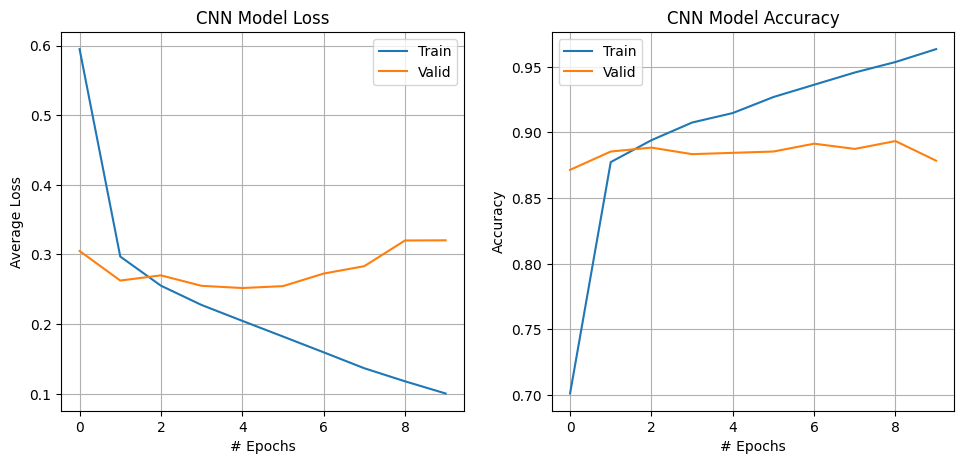

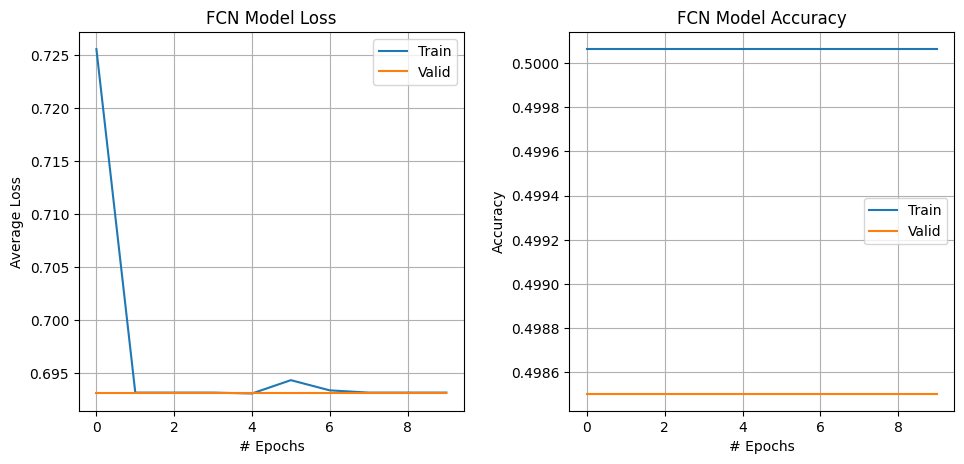

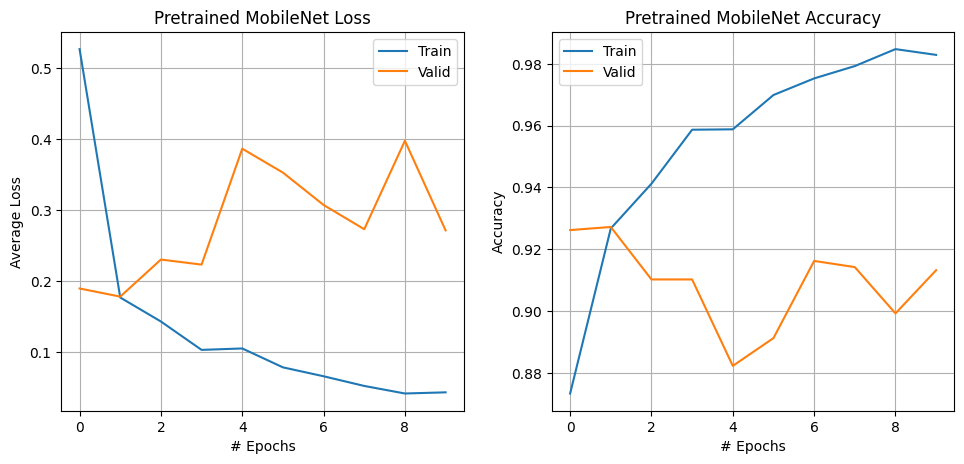

In [192]:
plotStatistics("CNN Model", 10, train_losses, train_accs, val_losses, val_accs)
plotStatistics("FCN Model", 10, FCNtrain_losses, FCNtrain_accs, FCNval_losses, FCNval_accs)
plotStatistics("Pretrained MobileNet", 10, pFCNtrain_losses, pFCNtrain_accs, pFCNval_losses, pFCNval_accs)

# Testing With Custom Images

In [193]:
def predict(img):
  new_image = img.resize((178, 178))
  new_image = np.array(new_image)/255.0
  new_image = (new_image - np.array([0.485, 0.456, 0.406])) / np.array([0.229, 0.224, 0.225])
  new_image = torch.Tensor(new_image.transpose(2, 0, 1)).unsqueeze(0) # Add batch dimension
  new_image = new_image.cuda() # Move tensor to GPU
  
  model.eval()
  with torch.no_grad():
      outputs = model(new_image)
  _, predicted = torch.max(outputs.data, 1)

  # Get the predicted class name
  class_names = {0: 'Not Smile', 1: 'Smile'}
  predicted_class = class_names[predicted.item()]
  return predicted_class

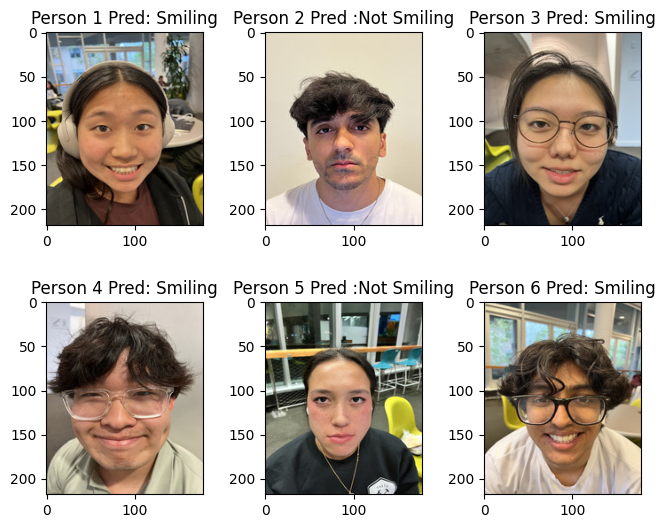

In [194]:
def display_images():
    # Load the images
    person1 = Image.open("./SmileData/testImg/EmilySmile178x218.jpeg")
    person3 = Image.open("./SmileData/testImg/YermSmile178x218.jpeg")
    person2 = Image.open("./SmileData/testImg/ShaNot178x218.jpeg")
    person4 = Image.open("./SmileData/testImg/MikeSmile178x218.jpeg")
    person5 = Image.open("./SmileData/testImg/KaiNot178x218.jpeg")
    person6 = Image.open("./SmileData/testImg/SajSmile178x218.jpeg")
    
    # Create a figure and axis objects
    fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(8, 6))
    
    # Display the images and set titles
    for i, img in enumerate([person1, person2, person3,
                             person4, person5, person6]):
        row = i // 3
        col = i % 3
        pred = predict(img) # acutaly prediction 
        title = f"Person {row * 3 + col + 1}{( ' Pred: Smiling' if pred == 'Smile' else ' Pred :Not Smiling')}"
        axs[row, col].imshow(img)
        axs[row, col].set_title(title)
    
    # Set the spacing and display the plot
    plt.subplots_adjust(wspace=0.2, hspace=0.4)
    plt.show()
display_images()

## Testing Smile/No Smile Through Camera

Below is a modified script pulled from Colab and another resource, which is followed by a cell where we tell you in live time through the camera whether you are smiling / not smiling!



CITE THIS IN CITATIONS AND REFERENCES https://colab.research.google.com/drive/1QnC7lV7oVFk5OZCm75fqbLAfD9qBy9bw?usp=sharing#scrollTo=09b_0FAnUa9y

In [195]:
# function to convert the JavaScript object into an OpenCV image
def js_to_image(js_reply):
  """
  Params:
          js_reply: JavaScript object containing image from webcam
  Returns:
          img: OpenCV BGR image
  """
  # decode base64 image
  image_bytes = b64decode(js_reply.split(',')[1])
  # convert bytes to numpy array
  jpg_as_np = np.frombuffer(image_bytes, dtype=np.uint8)
  # decode numpy array into OpenCV BGR image
  img = cv2.imdecode(jpg_as_np, flags=1)

  return img

# function to convert OpenCV Rectangle bounding box image into base64 byte string to be overlayed on video stream
def bbox_to_bytes(bbox_array):
  """
  Params:
          bbox_array: Numpy array (pixels) containing rectangle to overlay on video stream.
  Returns:
        bytes: Base64 image byte string
  """
  # convert array into PIL image
  bbox_PIL = PIL.Image.fromarray(bbox_array, 'RGBA')
  iobuf = io.BytesIO()
  # format bbox into png for return
  bbox_PIL.save(iobuf, format='png')
  # format return string
  bbox_bytes = 'data:image/png;base64,{}'.format((str(b64encode(iobuf.getvalue()), 'utf-8')))

  return bbox_bytes

In [196]:
from IPython.display import display, Javascript, Image
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)

In [197]:
# JavaScript to properly create our live video stream using our webcam as input
def video_stream():
  js = Javascript('''
    var video;
    var div = null;
    var stream;
    var captureCanvas;
    var imgElement;
    var labelElement;
    
    var pendingResolve = null;
    var shutdown = false;
    
    function removeDom() {
       stream.getVideoTracks()[0].stop();
       video.remove();
       div.remove();
       video = null;
       div = null;
       stream = null;
       imgElement = null;
       captureCanvas = null;
       labelElement = null;
    }
    
    function onAnimationFrame() {
      if (!shutdown) {
        window.requestAnimationFrame(onAnimationFrame);
      }
      if (pendingResolve) {
        var result = "";
        if (!shutdown) {
          captureCanvas.getContext('2d').drawImage(video, 0, 0, 640, 480);
          result = captureCanvas.toDataURL('image/jpeg', 0.8)
        }
        var lp = pendingResolve;
        pendingResolve = null;
        lp(result);
      }
    }
    
    async function createDom() {
      if (div !== null) {
        return stream;
      }

      div = document.createElement('div');
      div.style.border = '2px solid black';
      div.style.padding = '3px';
      div.style.width = '100%';
      div.style.maxWidth = '600px';
      document.body.appendChild(div);
      
      const modelOut = document.createElement('div');
      modelOut.innerHTML = "<span>Status:</span>";
      labelElement = document.createElement('span');
      labelElement.innerText = 'No data';
      labelElement.style.fontWeight = 'bold';
      modelOut.appendChild(labelElement);
      div.appendChild(modelOut);
           
      video = document.createElement('video');
      video.style.display = 'block';
      video.width = div.clientWidth - 6;
      video.setAttribute('playsinline', '');
      video.onclick = () => { shutdown = true; };
      stream = await navigator.mediaDevices.getUserMedia(
          {video: { facingMode: "environment"}});
      div.appendChild(video);

      imgElement = document.createElement('img');
      imgElement.style.position = 'absolute';
      imgElement.style.zIndex = 1;
      imgElement.onclick = () => { shutdown = true; };
      div.appendChild(imgElement);
      
      const instruction = document.createElement('div');
      instruction.innerHTML = 
          '<span style="color: red; font-weight: bold;">' +
          'When finished, click here or on the video to stop this demo</span>';
      div.appendChild(instruction);
      instruction.onclick = () => { shutdown = true; };
      
      video.srcObject = stream;
      await video.play();

      captureCanvas = document.createElement('canvas');
      captureCanvas.width = 640; //video.videoWidth;
      captureCanvas.height = 480; //video.videoHeight;
      window.requestAnimationFrame(onAnimationFrame);
      
      return stream;
    }
    async function stream_frame(label, imgData) {
      if (shutdown) {
        removeDom();
        shutdown = false;
        return '';
      }

      var preCreate = Date.now();
      stream = await createDom();
      
      var preShow = Date.now();
      if (label != "") {
        labelElement.innerHTML = label;
      }
            
      if (imgData != "") {
        var videoRect = video.getClientRects()[0];
        imgElement.style.top = videoRect.top + "px";
        imgElement.style.left = videoRect.left + "px";
        imgElement.style.width = videoRect.width + "px";
        imgElement.style.height = videoRect.height + "px";
        imgElement.src = imgData;
      }
      
      var preCapture = Date.now();
      var result = await new Promise(function(resolve, reject) {
        pendingResolve = resolve;
      });
      shutdown = false;
      
      return {'create': preShow - preCreate, 
              'show': preCapture - preShow, 
              'capture': Date.now() - preCapture,
              'img': result};
    }
    ''')

  display(js)
  
def video_frame(label, bbox):
  data = eval_js('stream_frame("{}", "{}")'.format(label, bbox))
  return data

def smileDetector():
  # initialize the Haar Cascade face detection model
  face_cascade = cv2.CascadeClassifier(cv2.samples.findFile(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml'))
  # start streaming video from webcam
  video_stream()
  # creating device
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  # label for video
  label_html = 'Capturing...'
  # initialze bounding box to empty
  bbox = ''
  count = 0 
  while True:
      js_reply = video_frame(label_html, bbox)
      if not js_reply:
          break

      # convert JS response to OpenCV Image
      img = js_to_image(js_reply["img"])

      # create transparent overlay for bounding box
      bbox_array = np.zeros([480,640,4], dtype=np.uint8)

      # grayscale image for face detection
      gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
      # do prediction on img
      # get face region coordinates
      faces = face_cascade.detectMultiScale(gray)
      # get face bounding box for overlay
      for (x,y,w,h) in faces:
        # code for writing smiling/not smiling
        roi = cv2.resize(img[y - 50:y + h + 50, x - 50:x + w + 50], (178, 178))
        cv2.imwrite("roi.png", roi)
        # roi = np.stack((roi,) * 3, axis=-1)
        roi = np.transpose(roi, (2, 0, 1))
        roi = roi.astype('float') / 255.0
        roi = img_to_array(roi)
        roi = np.expand_dims(roi, axis = 0)
        roi = torch.Tensor(roi).to(device)
        res = model(roi)
        _, predicted = torch.max(res.data, 1)
        if (predicted.item()):
          cv2.putText(bbox_array, "Smiling", (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.45, (0, 255, 0), 2)
          bbox_array = cv2.rectangle(bbox_array,(x,y),(x+w,y+h),(0,255,0),2)
        else:
          cv2.putText(bbox_array, "Not Smiling", (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.45, (255, 0, 0), 2)
          bbox_array = cv2.rectangle(bbox_array,(x,y),(x+w,y+h),(255,0,0),2)

      

      bbox_array[:,:,3] = (bbox_array.max(axis = 2) > 0 ).astype(int) * 255
      # convert overlay of bbox into bytes
      bbox_bytes = bbox_to_bytes(bbox_array)
      # update bbox so next frame gets new overlay
      bbox = bbox_bytes

Run the following cell to open up your camera and see in live time whether you're smiling or not!

In [198]:
smileDetector()

<IPython.core.display.Javascript object>